In [19]:
# Global Variables
stock_symbols = ["AAPL", "GOOGL", "MSFT", "AMZN", "TSLA"]
unseen_symbol = "META"
lookback = 10
n_models_per_type = 1  # 1 LightGBM and 1 LSTM per stock
data_dict = {}
scaled_data = {}
scalers = {}
lgbm_models = {}
lstm_models = {}
eval_results = {}

In [20]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

# Use global variables
global stock_symbols, unseen_symbol, lookback, n_models_per_type, data_dict, scaled_data, scalers, lgbm_models, eval_results

# Download and prepare data
def download_data(symbol):
    try:
        df = yf.download(symbol, period="5y")
        return df[['Close']].dropna()
    except Exception as e:
        print(f"Error downloading data for {symbol}: {e}")
        return None

# Initialize or update data_dict
for symbol in stock_symbols + [unseen_symbol]:
    if symbol not in data_dict or data_dict[symbol] is None:
        data_dict[symbol] = download_data(symbol)

# Scale data
for symbol in stock_symbols + [unseen_symbol]:
    if data_dict[symbol] is not None and not data_dict[symbol].empty:
        if symbol not in scalers:
            scalers[symbol] = MinMaxScaler(feature_range=(0, 1))
        if symbol not in scaled_data or scaled_data[symbol] is None:
            scaled_data[symbol] = scalers[symbol].fit_transform(data_dict[symbol])
    else:
        print(f"No data available for {symbol}, skipping scaling")
        scaled_data[symbol] = None

# Prepare sequences for LightGBM
def create_sequences_lgbm(data, lookback):
    if data is None or len(data) < lookback + 1:
        return np.array([]), np.array([])
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Train LightGBM models
for symbol in stock_symbols:
    if scaled_data[symbol] is None:
        print(f"Skipping {symbol} due to missing scaled data")
        continue
    print(f"Preparing data for {symbol} (LightGBM)")
    X_lgbm, y_lgbm = create_sequences_lgbm(scaled_data[symbol], lookback)
    if len(X_lgbm) == 0:
        print(f"No sequences created for {symbol}, skipping")
        continue
    print(f"X_lgbm shape for {symbol}: {X_lgbm.shape}")
    
    X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_lgbm, y_lgbm, test_size=0.2, shuffle=False)
    print(f"X_train_lgbm shape for {symbol}: {X_train_lgbm.shape}")
    
    if symbol not in eval_results:
        eval_results[symbol] = {"lgbm": []}
    lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, force_col_wise=True, n_jobs=1)
    lgbm.fit(X_train_lgbm, y_train_lgbm)
    lgbm_models[f'lgbm_{symbol}_0'] = lgbm
    y_pred = lgbm.predict(X_test_lgbm)
    eval_results[symbol]["lgbm"].append({
        "r2": r2_score(y_test_lgbm, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_test_lgbm, y_pred)),
        "mae": mean_absolute_error(y_test_lgbm, y_pred)
    })
    print(f"Trained LightGBM model for {symbol}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Preparing data for AAPL (LightGBM)
X_lgbm shape for AAPL: (1248, 10)
X_train_lgbm shape for AAPL: (998, 10)
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 998, number of used features: 10
[LightGBM] [Info] Start training from score 0.422266
Trained LightGBM model for AAPL
Preparing data for GOOGL (LightGBM)
X_lgbm shape for GOOGL: (1248, 10)
X_train_lgbm shape for GOOGL: (998, 10)
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 998, number of used features: 10
[LightGBM] [Info] Start training from score 0.363353
Trained LightGBM model for GOOGL
Preparing data for MSFT (LightGBM)
X_lgbm shape for MSFT: (1248, 10)
X_train_lgbm shape for MSFT: (998, 10)
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 998, number of used features: 10
[LightGBM] [Info] Start training from score 0.378568
Trained LightGBM model for MSFT
Preparing data for AMZN (LightGBM)
X_lgbm 

In [21]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Use global variables
global stock_symbols, lookback, n_models_per_type, data_dict, scaled_data, scalers, lstm_models, eval_results

# Prepare sequences for LSTM (aligned with your script)
def create_sequences(data, lookback):
    if data is None or len(data) < lookback + 1:
        raise ValueError(f"Insufficient data for sequencing: {len(data)} < {lookback + 1}")
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape to 3D
    return X, np.array(y)

# Train LSTM models
for symbol in stock_symbols:
    if scaled_data[symbol] is None:
        print(f"Skipping {symbol} due to missing scaled data")
        continue
    print(f"Preparing data for {symbol} (LSTM)")
    X_lstm, y_lstm = create_sequences(scaled_data[symbol], lookback)
    print(f"X_lstm shape for {symbol}: {X_lstm.shape}")
    
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)
    print(f"X_train_lstm shape for {symbol}: {X_train_lstm.shape}")
    
    if symbol not in eval_results:
        eval_results[symbol] = {"lstm": []}
    elif "lstm" not in eval_results[symbol]:
        eval_results[symbol]["lstm"] = []
    
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(f"LSTM input shape for {symbol}: {X_train_lstm.shape}")
    model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=1)
    lstm_models[f'lstm_{symbol}_0'] = model
    y_pred = model.predict(X_test_lstm, verbose=0)
    if y_pred.shape[1] != 1:
        y_pred = y_pred.reshape(-1, 1)
    eval_results[symbol]["lstm"].append({
        "r2": r2_score(y_test_lstm, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_test_lstm, y_pred)),
        "mae": mean_absolute_error(y_test_lstm, y_pred)
    })
    print(f"Trained LSTM model for {symbol}")

Preparing data for AAPL (LSTM)
X_lstm shape for AAPL: (1248, 10, 1)
X_train_lstm shape for AAPL: (998, 10, 1)
LSTM input shape for AAPL: (998, 10, 1)
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0728
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0

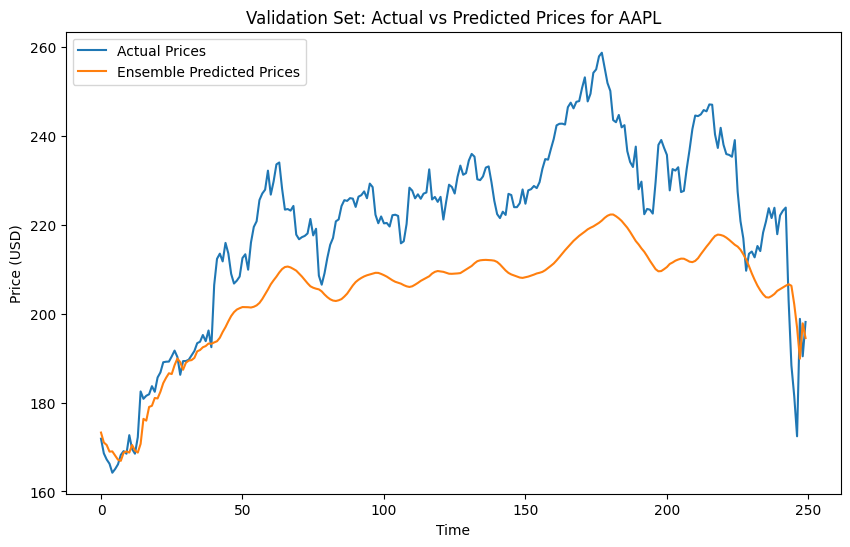

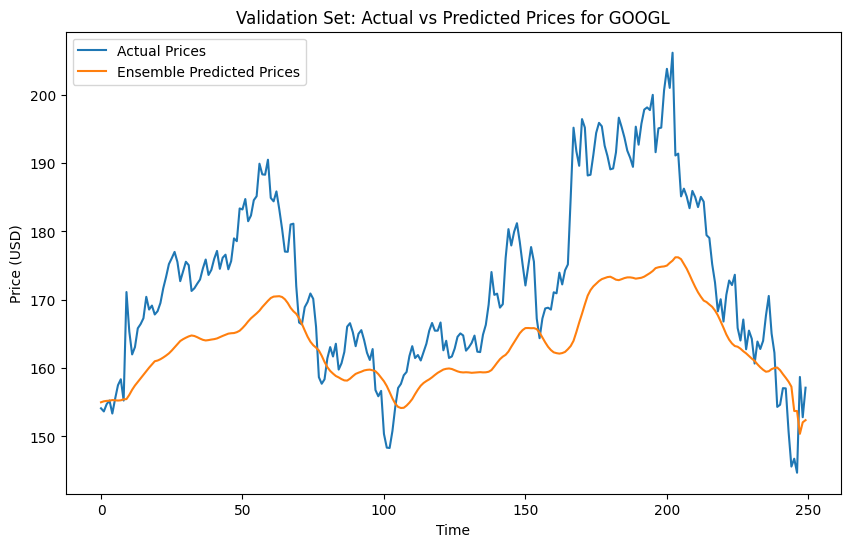

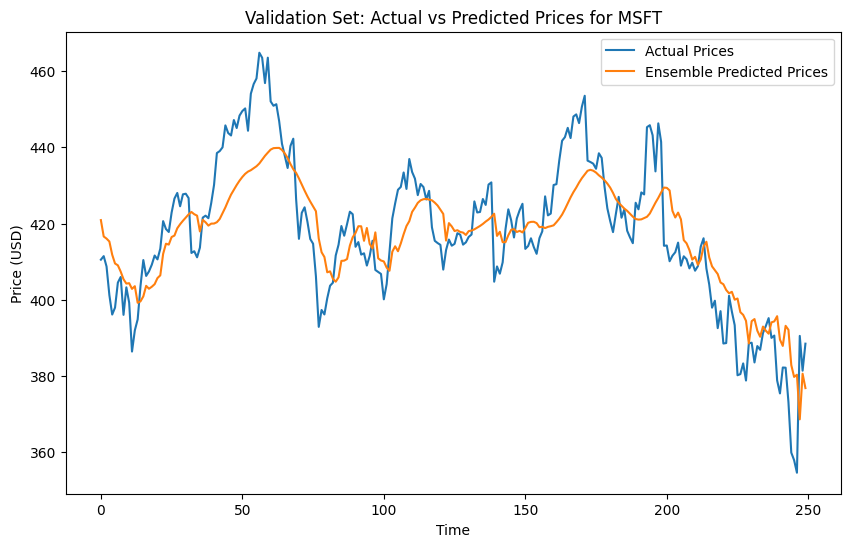

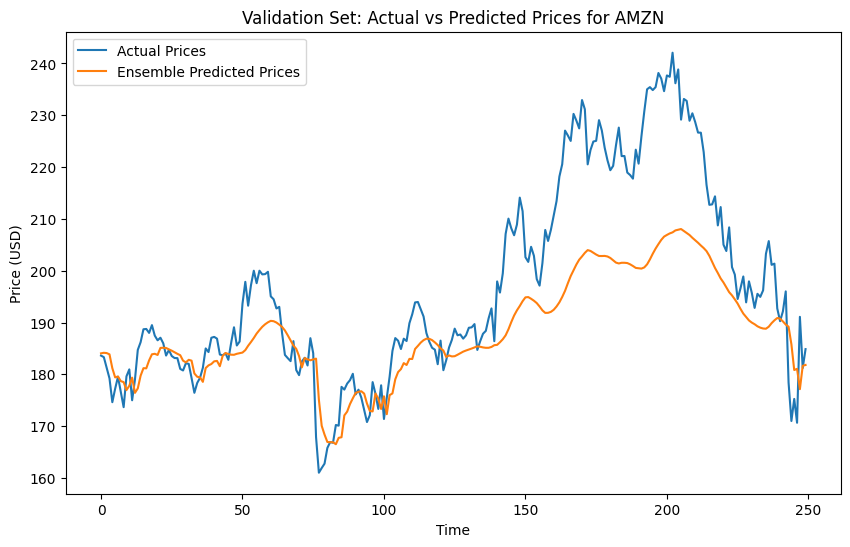

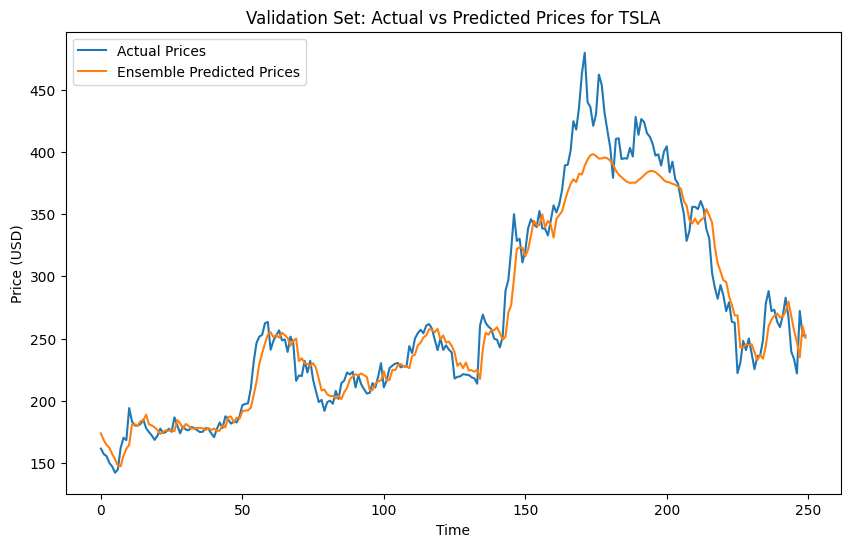

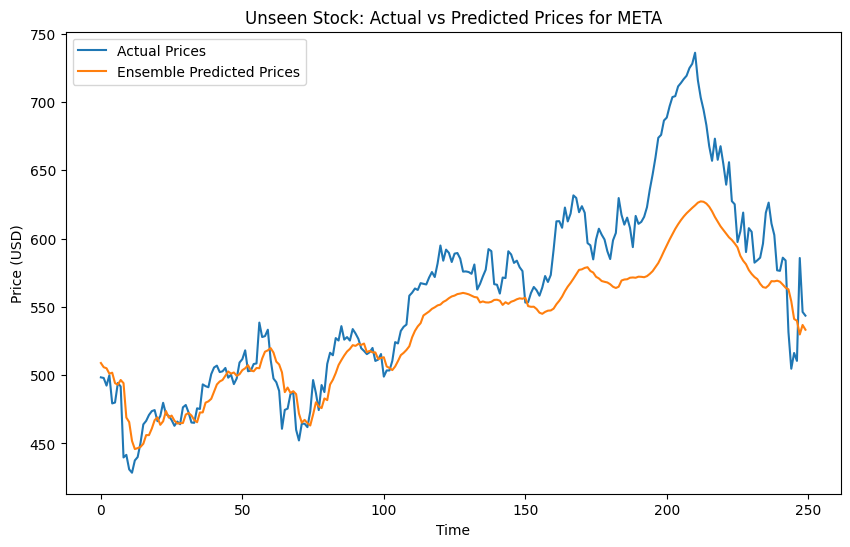


Evaluation for AAPL:
LightGBM: R²=-1.6137, RMSE=0.1755, MAE=0.1536
LSTM: R²=0.8553, RMSE=0.0413, MAE=0.0312
Ensemble: R²=0.2313, RMSE=0.0952, MAE=0.0828

Evaluation for GOOGL:
LightGBM: R²=-1.9971, RMSE=0.1526, MAE=0.1275
LSTM: R²=0.8056, RMSE=0.0389, MAE=0.0296
Ensemble: R²=0.1327, RMSE=0.0821, MAE=0.0669

Evaluation for MSFT:
LightGBM: R²=0.4833, RMSE=0.0463, MAE=0.0342
LSTM: R²=0.6636, RMSE=0.0374, MAE=0.0314
Ensemble: R²=0.6903, RMSE=0.0359, MAE=0.0292

Evaluation for AMZN:
LightGBM: R²=-0.3919, RMSE=0.1414, MAE=0.0969
LSTM: R²=0.8738, RMSE=0.0426, MAE=0.0330
Ensemble: R²=0.5111, RMSE=0.0838, MAE=0.0609

Evaluation for TSLA:
LightGBM: R²=0.9064, RMSE=0.0577, MAE=0.0359
LSTM: R²=0.9433, RMSE=0.0449, MAE=0.0327
Ensemble: R²=0.9433, RMSE=0.0449, MAE=0.0311

Evaluation for META:
Ensemble (unseen): R²=0.7184, RMSE=0.0567, MAE=0.0416
Single-point Ensemble (unseen): R²=nan, RMSE=0.0159, MAE=0.0159
Predicted closing price for META: $533.27


TypeError: unsupported format string passed to Series.__format__

In [24]:
# Fourth Part (corrected)

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Use global variables
global stock_symbols, unseen_symbol, lookback, n_models_per_type, data_dict, scaled_data, scalers, lgbm_models, lstm_models, eval_results

# Prepare sequences for prediction
def create_sequences(data, lookback):
    if data is None or len(data) < lookback + 1:
        raise ValueError(f"Insufficient data for sequencing: {len(data)} < {lookback + 1}")
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape to 3D
    return X, np.array(y)

# Ensemble prediction using all 10 models (trained on stock_symbols)
def ensemble_predict(models, X_lstm):
    predictions = []
    for model_name, model in models.items():
        if 'lgbm' in model_name:
            X_lgbm = X_lstm.reshape(1, -1)  # Flatten for LightGBM
            pred = model.predict(X_lgbm)[0]
        else:  # LSTM
            pred = model.predict(X_lstm, verbose=0)[0][0]
        predictions.append(pred)
    return np.mean(predictions)

# Evaluate and plot for validation sets
for symbol in stock_symbols:
    if scaled_data[symbol] is None:
        print(f"Skipping {symbol} due to missing scaled data")
        continue
    X_lstm, y_lstm = create_sequences(scaled_data[symbol], lookback)
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)
    
    # Get predictions from all models for the current symbol
    lgbm_val_preds = np.array([m.predict(X_test_lstm.reshape(X_test_lstm.shape[0], -1)) for m in [lgbm_models[f'lgbm_{symbol}_0']]])
    lstm_val_preds = np.array([m.predict(X_test_lstm, verbose=0) for m in [lstm_models[f'lstm_{symbol}_0']]])
    if lgbm_val_preds.shape[1:] != lstm_val_preds.shape[1:]:
        lgbm_val_preds = lgbm_val_preds.reshape(lstm_val_preds.shape)  # Ensure same shape
    ensemble_val_preds = np.mean(np.concatenate([lgbm_val_preds, lstm_val_preds], axis=0), axis=0)
    
    # Inverse transform predictions and actual values
    y_test_actual = scalers[symbol].inverse_transform(y_test_lstm.reshape(-1, 1))
    ensemble_val_preds_actual = scalers[symbol].inverse_transform(ensemble_val_preds.reshape(-1, 1))
    
    # Store metrics
    if symbol not in eval_results:
        eval_results[symbol] = {"ensemble": {}}
    eval_results[symbol]["ensemble"] = {
        "r2": r2_score(y_test_lstm, ensemble_val_preds),
        "rmse": np.sqrt(mean_squared_error(y_test_lstm, ensemble_val_preds)),
        "mae": mean_absolute_error(y_test_lstm, ensemble_val_preds)
    }
    
    # Plot validation results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label='Actual Prices')
    plt.plot(ensemble_val_preds_actual, label='Ensemble Predicted Prices')
    plt.title(f'Validation Set: Actual vs Predicted Prices for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

# Predict for unseen stock (META) using the 10 models trained on stock_symbols
if scaled_data[unseen_symbol] is None:
    print(f"No data available for {unseen_symbol}")
else:
    # Prepare META data
    unseen_X_full, y_unseen = create_sequences(scaled_data[unseen_symbol], lookback)
    X_train_unseen, X_test_unseen, y_train_unseen, y_test_unseen = train_test_split(unseen_X_full, y_unseen, test_size=0.2, shuffle=False)
    
    # Ensemble prediction using all 10 models (5 LSTM + 5 LightGBM)
    all_models = {**lgbm_models, **lstm_models}  # Contains lgbm/lstm for AAPL, GOOGL, MSFT, AMZN, TSLA
    lstm_preds = [m.predict(X_test_unseen, verbose=0) for m in [lstm_models[f'lstm_{sym}_0'] for sym in stock_symbols]]
    lgbm_preds = [m.predict(X_test_unseen.reshape(X_test_unseen.shape[0], -1)).reshape(-1, 1) for m in [lgbm_models[f'lgbm_{sym}_0'] for sym in stock_symbols]]
    all_preds = lstm_preds + lgbm_preds  # Combine predictions
    ensemble_unseen_preds = np.mean(np.stack(all_preds, axis=0), axis=0).flatten()  # Stack and average
    
    # Inverse transform predictions and actual values
    y_test_unseen_actual = scalers[unseen_symbol].inverse_transform(y_test_unseen.reshape(-1, 1))
    ensemble_unseen_preds_actual = scalers[unseen_symbol].inverse_transform(ensemble_unseen_preds.reshape(-1, 1))
    
    # Store metrics
    if unseen_symbol not in eval_results:
        eval_results[unseen_symbol] = {"ensemble": {}}
    eval_results[unseen_symbol]["ensemble"] = {
        "r2": r2_score(y_test_unseen, ensemble_unseen_preds),
        "rmse": np.sqrt(mean_squared_error(y_test_unseen, ensemble_unseen_preds)),
        "mae": mean_absolute_error(y_test_unseen, ensemble_unseen_preds)
    }
    
    # Plot META prediction
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_unseen_actual, label='Actual Prices')
    plt.plot(ensemble_unseen_preds_actual, label='Ensemble Predicted Prices')
    plt.title(f'Unseen Stock: Actual vs Predicted Prices for {unseen_symbol}')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()
    
    # Single-point prediction for the latest sequence
    unseen_X = unseen_X_full[-1:]  # Last sequence
    final_pred_scaled = ensemble_predict(all_models, unseen_X)
    final_pred = scalers[unseen_symbol].inverse_transform([[final_pred_scaled]])[0][0]
    
    # Evaluate single-point prediction
    latest_meta_scaled = y_unseen[-1]  # Last actual value
    eval_results[unseen_symbol]["ensemble_single"] = {
        "r2": r2_score([latest_meta_scaled], [final_pred_scaled]),
        "rmse": np.sqrt(mean_squared_error([latest_meta_scaled], [final_pred_scaled])),
        "mae": mean_absolute_error([latest_meta_scaled], [final_pred_scaled])
    }

# Output results
for symbol in stock_symbols + [unseen_symbol]:
    print(f"\nEvaluation for {symbol}:")
    if symbol in stock_symbols:
        if "lgbm" in eval_results[symbol]:
            print(f"LightGBM: R²={eval_results[symbol]['lgbm'][0]['r2']:.4f}, "
                  f"RMSE={eval_results[symbol]['lgbm'][0]['rmse']:.4f}, "
                  f"MAE={eval_results[symbol]['lgbm'][0]['mae']:.4f}")
        if "lstm" in eval_results[symbol]:
            print(f"LSTM: R²={eval_results[symbol]['lstm'][0]['r2']:.4f}, "
                  f"RMSE={eval_results[symbol]['lstm'][0]['rmse']:.4f}, "
                  f"MAE={eval_results[symbol]['lstm'][0]['mae']:.4f}")
        print(f"Ensemble: R²={eval_results[symbol]['ensemble']['r2']:.4f}, "
              f"RMSE={eval_results[symbol]['ensemble']['rmse']:.4f}, "
              f"MAE={eval_results[symbol]['ensemble']['mae']:.4f}")
    else:
        print(f"Ensemble (unseen): R²={eval_results[symbol]['ensemble']['r2']:.4f}, "
              f"RMSE={eval_results[symbol]['ensemble']['rmse']:.4f}, "
              f"MAE={eval_results[symbol]['ensemble']['mae']:.4f}")
        print(f"Single-point Ensemble (unseen): R²={eval_results[symbol]['ensemble_single']['r2']:.4f}, "
              f"RMSE={eval_results[symbol]['ensemble_single']['rmse']:.4f}, "
              f"MAE={eval_results[symbol]['ensemble_single']['mae']:.4f}")
    if symbol == unseen_symbol:
        print(f"Predicted closing price for {unseen_symbol}: ${final_pred:.2f}")
        print(f"Latest known {unseen_symbol} closing price: ${data_dict[unseen_symbol]['Close'].iloc[-1]:.2f}")